# Predição de modelos por meio de SAVIME e PYSAVIME 

__O objetivo deste notebook é demonstrar o recurso de predição e execução de modelos, 
por meio do sistema SAVIME em conjunto com a biblioteca de acesso PySavime. Serão utilizados os modelos e dados criados no notebook Tutorial - Parte 01.__

Para execução deste tutorial é necessário que estejam inicializados o tfx e Savime. Observe abaixo as variáveis `savime_host`, `savime_port`, `tfx_host`, e `tfx_port` que apontam respectivamente para os hosts e portas em que Savime e TFX estão executando.

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2


import os
import sys

if not 'notebooks' in os.listdir('.'):
    current_dir = os.path.abspath(os.getcwd())
    parent_dir = os.path.dirname(current_dir)
    os.chdir(parent_dir)

# Informado o caminho do arquivo de dados: um json contendo informações a respeito 
# da partição de x e y utilizada na parte 01.
data_file = 'saved_models_elastic_net/data.json'

# Configuração do host e porta em que o SAVIME está escutando
savime_host = '127.0.0.1'
savime_port = 65000

tfx_host = '127.0.0.1'
tfx_port  = 8501

Abaixo é realizada a inclusão das módulos necessários para execução deste notebook. Atente para a inclusão da biblioteca pysame.

In [83]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Savime imports
import pysavime
from pysavime.util.converter import DataVariableBlockConverter
from pysavime.util.data_variable import DataVariableBlockOps

# Importa cliente de predição Python para TFX
from src.predictor_consumer import PredictionConsumer
from src.util import read_numpy_array_from_disk, export_numpy_array_to_c_array

# Omissão de warnings do tensorflow
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

Abaixo são carregados os dados produzidos no Turorial 1.

In [6]:
# Leitura do arquivo de dados .json de entrada
with open(data_file, 'r') as _in:
    data = json.load(_in)

# Leitura dos arrays X e Y
output_dir = data['output_dir']

# Definição dos diretórios 
x_file_path = os.path.join(output_dir, data['x_file_name'])
y_file_path = os.path.join(output_dir, data['y_file_name'])
x_c_file_path = os.path.join(output_dir, 'x_data')
y_c_file_path = os.path.join(output_dir, 'y_data')

# Convertendo os dados gerados para formato compatível com SAVIME
x_array = read_numpy_array_from_disk(x_file_path)
y_array = read_numpy_array_from_disk(y_file_path)
export_numpy_array_to_c_array(x_array, 'float64', x_c_file_path)
export_numpy_array_to_c_array(y_array, 'float64', y_c_file_path)

A seguir definimos os comandos necessários para a construção e carga dos dados que iremos utilizar para os testes no Savime

In [21]:
# Definição dos datasets a serem utilizados:
num_observations = len(x_array)
num_features     = x_array.shape[1]
y_num_columns    = y_array.shape[1] if len(y_array.shape) == 2 else 1 

x_dataset = pysavime.define.file_dataset('x', x_c_file_path, 'double', length=num_features)
y_dataset = pysavime.define.file_dataset('y', y_c_file_path, 'double', length=y_num_columns)

# Definição do Tar a ser empregado:
index = pysavime.define.implicit_tar_dimension('index', 'int32', 1, num_observations)
x = pysavime.define.tar_attribute('x', 'double', num_features)
y = pysavime.define.tar_attribute('y', 'double', y_num_columns)
tar = pysavime.define.tar('tutorial', [index], [x, y])

# Definição dos comandos de carga do SubTar:
subtar_index = pysavime.define.ordered_subtar_dimension(index, 1, num_observations)
subtar_x = pysavime.define.subtar_attribute(x, x_dataset)
subtar_y = pysavime.define.subtar_attribute(y, y_dataset)
subtar = pysavime.define.subtar(tar, [subtar_index], [subtar_x, subtar_y])

# Os comandos gerados serão:
print(x_dataset.create_query_str(), y_dataset.create_query_str(), sep='\n')
print(tar.create_query_str())
print(subtar.load_query_str())

CREATE_DATASET("x:double:2", "@/home/daniel/PycharmProjects/savime-notebooks/saved_models_elastic_net/x_data");
CREATE_DATASET("y:double:1", "@/home/daniel/PycharmProjects/savime-notebooks/saved_models_elastic_net/y_data");
CREATE_TAR("tutorial", "*", "implicit, index, int32, 1, 100000, 1", "x, double: 2 | y, double: 1");
LOAD_SUBTAR("tutorial", "ordered, index, #1,#100000", "x, x | y, y")


Por fim, executamos no servidor os comandos previamente definidos. 

1. Conexão é aberta e fechada com o SAVIME (contexto with)
2. Criação de um objeto de execução de comandos vinculado à conexão criada.
3. 
  1. Criação dos datasets
  2. Criação do subtar
  3. Carregamento dos datasets por meio de um subtar


In [15]:
with pysavime.Client(host=savime_host, port=savime_port) as client:
    client.execute(pysavime.operator.create(x_dataset))
    client.execute(pysavime.operator.create(y_dataset))
    client.execute(pysavime.operator.create(tar))
    client.execute(pysavime.operator.load(subtar))

A seguir, para cada modelo salvo, obtemos o erro médio quadrático da predição no domínio de dados.
Para isso, executamos os seguintes passos: 
1. Registrar o modelo no sistema: `pysavime.operator.register_model`
2. Executar a consulta preditiva: `pysavime.operator.predict`
3. Calculamos a diferença ao quadrado entre o retorno da consulta preditiva e o valor real y: `pysavime.operator.derive`
4. A partir deste valor, calculamos o erro médio quadrático `pysavime.operator.aggregate`

In [54]:
mse = {}
registered_models = data['iid']

with pysavime.Client(host=savime_host, port=savime_port) as client:
    # Elemento que especifica o tamanho da janela da consulta preditiva. 
    # É uma lista de pares, em que o primeiro elemento especifica a dimensão, 
    # e o segundo a quantidade de elementos. 
    dim_spec = [(index.name, num_observations)]
    
    for model_name, i in registered_models.items():
        # Um modelo é registrado no savime, isto é, associado a um tar, identificado qual o atributo de entrada e
        # o formato da matriz multidimensional de entrada. Nesse caso, estamos enviando o vetor completo de 
        # observações, mas é totalmente possível pedir uma predição para somente uma parte dele.
        
        # Registro do modelo que será utilizado
        register_cmd = pysavime.operator.register_model(model_name=model_name, model_tar=tar.name, input_attribute=x.name,
                                               dim_specification=dim_spec)
        client.execute(register_cmd)
        
        # Cálculo do erro médio quadrático
        predict_cmd = pysavime.operator.predict(tar=tar.name, model_name=model_name, input_attribute=x.name)
        derive_cmd = pysavime.operator.derive(predict_cmd, 'squared_difference', '(op_result - y)^2')
        aggregate_cmd = pysavime.operator.aggregate(derive_cmd, 'avg', 'squared_difference', 'mse')
        mse[model_name] = client.execute(aggregate_cmd)        

In [53]:
df['squared_difference'].mean()

0    6.325625
dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

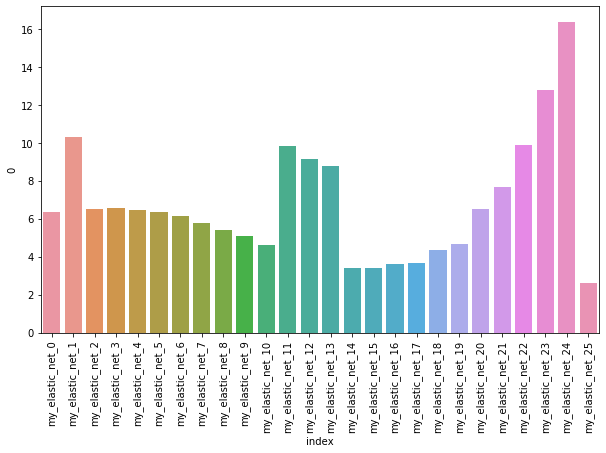

In [91]:
d = {key: value[0].attrs['mse'][0][0] for key, value in mse.items()}
df = pd.DataFrame.from_dict(d, orient='index')
df['index'] = df.index
df['index2'] = df['index'].apply(lambda x: int(x.split('_')[-1]))
df = df.sort_values('index2')

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.barplot(x='index', y=0, data=df, ax=ax)
plt.xticks(rotation=90)